c:\Users\borys\OneDrive\Documents\Projects\Python\Stock-Prediction-DeepLearning\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
[*********************100%***********************]  1 of 1 completed


Shape: (1738, 1)


c:\Users\borys\OneDrive\Documents\Projects\Python\Stock-Prediction-DeepLearning\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0265 - val_loss: 4.2649e-04
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.5319e-04 - val_loss: 2.7470e-04
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0114e-04 - val_loss: 2.6214e-04
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7568e-04 - val_loss: 5.2470e-04
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.6299e-04 - val_loss: 3.2066e-04
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.5061e-04 - val_loss: 2.5624e-04
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.1015e-04 - val_loss: 3.9728e-04
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.1692e-04 - val_loss: 1.7618e-04
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.4683e-04 - val_loss: 1.5763e-04
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9210e-04 - val_loss: 2.4378e-04
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.

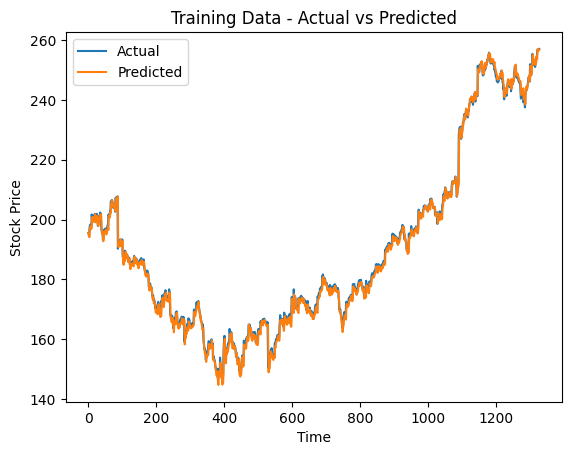

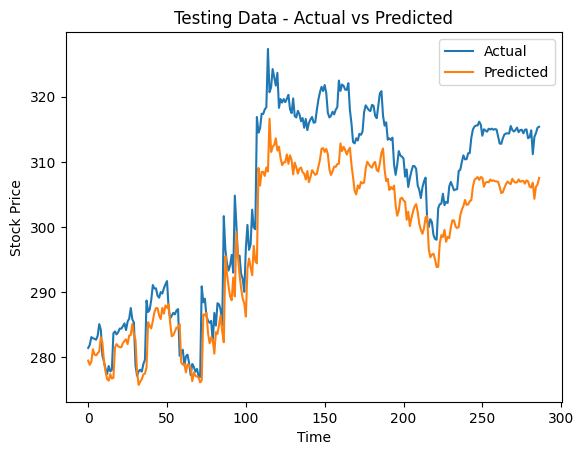

In [1]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Download historical stock data (e.g., Apple)
data = yf.download("GOOG", period='1y', interval='1h')
data = data[["Close"]]  # Use only closing price

# Normalize data
scaler = MinMaxScaler()
data["Close"] = scaler.fit_transform(np.array(data["Close"]).reshape(-1, 1))

print("Shape:", data.shape)

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Create dataset with lookback period (e.g., 60 days)
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset['Close'][i:(i + look_back)].values  # Access 'Close' column and convert to NumPy array
        X.append(a)
        # Access 'Close' column by name using .iloc for integer-based indexing
        Y.append(dataset['Close'].iloc[i + look_back])  
    return np.array(X), np.array(Y)

look_back = 60
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(SimpleRNN(units=50))
model.add(Dense(1))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))  # Reshape Y_train before inverse transform
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape Y_test before inverse transform

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Calculate root mean squared error (RMSE)
train_rmse = math.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test, test_predict))
print('Train RMSE: %.3f' % (train_rmse))
print('Test RMSE: %.3f' % (test_rmse))

# Calculate mean absolute error (MAE)
train_mae = mean_absolute_error(Y_train, train_predict)
test_mae = mean_absolute_error(Y_test, test_predict)
print('Train MAE: %.3f' % (train_mae))
print('Test MAE: %.3f' % (test_mae))

# Plot the results
import matplotlib.pyplot as plt

# Plot the training data and predictions
plt.plot(Y_train, label='Actual')
plt.plot(train_predict, label='Predicted')
plt.title('Training Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Plot the testing data and predictions
plt.plot(Y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.title('Testing Data - Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()